In [119]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook


In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import seaborn as sns

In [144]:
# Load the SQL query from the file
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    snowhook = SnowflakeHook()
    df = snowhook.query_snowflake(query, method='pandas')

    # format decimal to float
    for col in df.columns:
        if df[col].dtype == 'object' and isinstance(df[col].dropna().iloc[0], Decimal):
            df[col] = df[col].astype(float)

    return df

In [122]:
daco_spend_to_applicants_curve = load_query('daco_spend_to_applicants.sql')
new_dx_landing_curve = load_query('apps_to_new_dx_landing_curve.sql')
new_dx_retention_curve = load_query('new_dx_retention.sql')

2025-08-19 23:28:09,822 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-08-19 23:28:09,823 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-08-19 23:28:10,164 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-08-19 23:28:10,166 - utils.snowflake_connection - INFO - Executing query (pandas)
2025-08-19 23:28:10,728 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-08-19 23:28:10,729 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-08-19 23:28:11,037 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-08-19 23:28:11,038 - utils.snowflake_connection - INFO - Executing query (pandas)
2025-08-19 23:28:11,628 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-08-19 23:28:11,630 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-08-19 23:28:11,954 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-08-19 23:28:11,955 - utils.snowflake_connection - INFO - Executing query (pandas)


In [123]:
# aggregate daco spend to applicants curve
def spend_to_apps(daco_spend_to_applicants_curve, sm_list):

    df = daco_spend_to_applicants_curve.copy()
    df = df[df['submarket_id'].isin(sm_list)].reset_index(drop = True)
    df_agg = df.groupby('mcpd_scenario').agg({'spending': 'mean', 'applicants': 'sum', 'new_dx': 'sum'}).reset_index(drop = False)
    df_agg['cost_per_new_dx'] = df_agg['spending'] / df_agg['new_dx']
    df_agg['spend_horizon'] = 0 # assign horizon 0 to all rows

    # check mCPD
    df_agg['spending_diff'] = df_agg['spending'].diff()
    df_agg['new_dx_diff'] = df_agg['new_dx'].diff()

    # Calculate marginal cost per new dx
    df_agg['marginal_cost_per_new_dx'] = df_agg['spending_diff'] / df_agg['new_dx_diff']

    df_agg['new_dx_ratio_daco'] =  df_agg['new_dx'] / df_agg['applicants']

    return df_agg

In [124]:
sm_list = [81]

df_spend_to_apps = spend_to_apps(daco_spend_to_applicants_curve, sm_list)
df_spend_to_apps

,mcpd_scenario,spending,applicants,new_dx,cost_per_new_dx,spend_horizon,spending_diff,new_dx_diff,marginal_cost_per_new_dx,new_dx_ratio_daco
0,1000,6000.00000,62.335022,14.048610,427.088528,0,NaN,NaN,NaN,0.225373
1,2000,21107.51979,106.632143,24.957345,845.743783,0,15107.51979,10.908736,1384.901054,0.234051
2,3000,41105.72579,143.256268,34.425850,1194.036628,0,19998.20600,9.468504,2112.076527,0.240310
3,4000,60105.72579,164.410262,40.602021,1480.362902,0,19000.00000,6.176171,3076.339603,0.246956
4,5000,81515.97379,182.970834,46.032575,1770.832379,0,21410.24800,5.430554,3942.553481,0.251584
5,6000,93233.73798,192.899757,48.193399,1934.574837,0,11717.76419,2.160825,5422.820193,0.249836
6,7000,99251.92898,197.646800,49.162780,2018.842906,0,6018.19100,0.969380,6208.287554,0.248741
7,8000,104151.92898,201.762452,49.992964,2083.331736,0,4900.00000,0.830185,5902.302038,0.247781
8,9000,109551.92898,205.793469,50.807572,2156.212632,0,5400.00000,0.814608,6628.955587,0.246886
9,10000,113669.01738,208.878536,51.494326,2207.408578,0,4117.08840,0.686754,5994.997380,0.246528


In [ ]:
df_new_dx = new_dx_landing_curve.merge(df_spend_to_apps, how='cross')
df_new_dx['new_dx_by_horizon'] = df_new_dx['new_dx_ratio'] * df_new_dx['applicants']
df_new_dx

,horizon,new_dx_ratio,mcpd_scenario,spending,applicants,new_dx,cost_per_new_dx,spend_horizon,spending_diff,new_dx_diff,marginal_cost_per_new_dx,new_dx_ratio_daco,new_dx_by_horizon
0,0,0.104181,1000,6000.00000,62.335022,14.048610,427.088528,0,NaN,NaN,NaN,0.225373,6.494120
1,0,0.104181,2000,21107.51979,106.632143,24.957345,845.743783,0,15107.51979,10.908736,1384.901054,0.234051,11.109035
2,0,0.104181,3000,41105.72579,143.256268,34.425850,1194.036628,0,19998.20600,9.468504,2112.076527,0.240310,14.924570
3,0,0.104181,4000,60105.72579,164.410262,40.602021,1480.362902,0,19000.00000,6.176171,3076.339603,0.246956,17.128413
4,0,0.104181,5000,81515.97379,182.970834,46.032575,1770.832379,0,21410.24800,5.430554,3942.553481,0.251584,19.062070
...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,52,0.000737,8000,104151.92898,201.762452,49.992964,2083.331736,0,4900.00000,0.830185,5902.302038,0.247781,0.148792
632,52,0.000737,9000,109551.92898,205.793469,50.807572,2156.212632,0,5400.00000,0.814608,6628.955587,0.246886,0.151765
633,52,0.000737,10000,113669.01738,208.878536,51.494326,2207.408578,0,4117.08840,0.686754,5994.997380,0.246528,0.154040
634,52,0.000737,11000,114804.33938,212.196025,52.271888,2196.292177,0,1135.32200,0.777562,1460.104582,0.246338,0.156486


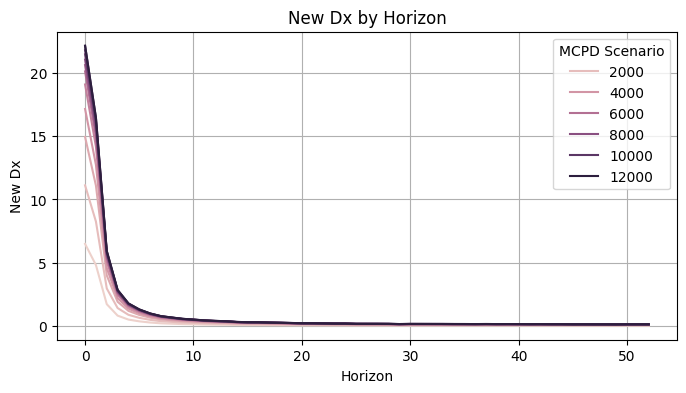

In [126]:
# viev 1: new dx over 52 weeks by different mcpd scenarios
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_new_dx, x='horizon', y='new_dx_by_horizon', hue='mcpd_scenario')

# Customize the plot
plt.title('New Dx by Horizon')
plt.xlabel('Horizon')
plt.ylabel('New Dx')
plt.legend(title='MCPD Scenario')
plt.grid(True)

# Show the plot
plt.show()

In [127]:
df_new_dx_metric = df_new_dx.groupby(['mcpd_scenario','spending','applicants']).agg({'new_dx_by_horizon': 'sum'}).reset_index(drop = False)
df_new_dx_metric['new_dx_ratio'] = df_new_dx_metric['new_dx_by_horizon'] / df_new_dx_metric['applicants']

df_new_dx_metric

,mcpd_scenario,spending,applicants,new_dx_by_horizon,new_dx_ratio
0,1000,6000.00000,62.335022,18.565518,0.297834
1,2000,21107.51979,106.632143,31.758727,0.297834
2,3000,41105.72579,143.256268,42.666653,0.297834
3,4000,60105.72579,164.410262,48.967042,0.297834
4,5000,81515.97379,182.970834,54.495020,0.297834
5,6000,93233.73798,192.899757,57.452195,0.297834
6,7000,99251.92898,197.646800,58.866028,0.297834
7,8000,104151.92898,201.762452,60.091811,0.297834
8,9000,109551.92898,205.793469,61.292387,0.297834
9,10000,113669.01738,208.878536,62.211226,0.297834


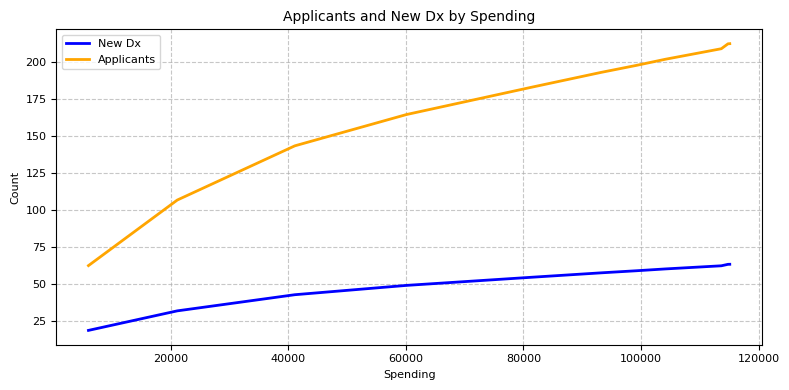

In [128]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the first line (new_dx_by_horizon)
ax.plot(df_new_dx_metric['spending'], df_new_dx_metric['new_dx_by_horizon'], color='blue', linewidth=2, label='New Dx')

# Plot the second line (applicants)
ax.plot(df_new_dx_metric['spending'], df_new_dx_metric['applicants'], color='orange', linewidth=2, label='Applicants')

# Customize the plot
ax.set_xlabel('Spending', color='black', fontsize=8)
ax.set_ylabel('Count', color='black', fontsize=8)
ax.tick_params(axis='x', labelcolor='black', labelsize=8)
ax.tick_params(axis='y', labelcolor='black', labelsize=8)
plt.title('Applicants and New Dx by Spending', fontsize=10)
ax.grid(True, linestyle='--', alpha=0.7)

# Add legends
ax.legend(loc='upper left', fontsize=8)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df_new_dx_retention = new_dx_retention_curve.merge(df_new_dx, how='cross')
df_new_dx_retention = df_new_dx_retention[['mcpd_scenario','spending','applicants','horizon','new_dx_by_horizon','tenure','pct_retained','online_hours','cum_sum_hr']]
df_new_dx_retention['retained_new_dx'] = df_new_dx_retention['new_dx_by_horizon'] * df_new_dx_retention['pct_retained']
df_new_dx_retention['retained_online_hours'] = df_new_dx_retention['retained_new_dx'] * df_new_dx_retention['online_hours']
df_new_dx_retention['week'] = df_new_dx_retention['horizon'] + df_new_dx_retention['tenure'].astype(int)

,tenure,tot_active_dx,tot_baseline_dx,pct_cum_sum,cum_sum_hr,cum_sum_hr_20perc,cum_sum_hr_50perc,cum_sum_hr_75perc,pct_retained,online_hours,...,spending,applicants,new_dx,cost_per_new_dx,spend_horizon,spending_diff,new_dx_diff,marginal_cost_per_new_dx,new_dx_ratio_daco,new_dx_by_horizon
0,0.0,414939,426488,0.303006,8.401401,2.105556,4.809722,10.686111,0.972921,8.401401,...,6000.00000,62.335022,14.048610,427.088528,0,NaN,NaN,NaN,0.225373,6.494120
1,0.0,414939,426488,0.303006,8.401401,2.105556,4.809722,10.686111,0.972921,8.401401,...,21107.51979,106.632143,24.957345,845.743783,0,15107.51979,10.908736,1384.901054,0.234051,11.109035
2,0.0,414939,426488,0.303006,8.401401,2.105556,4.809722,10.686111,0.972921,8.401401,...,41105.72579,143.256268,34.425850,1194.036628,0,19998.20600,9.468504,2112.076527,0.240310,14.924570
3,0.0,414939,426488,0.303006,8.401401,2.105556,4.809722,10.686111,0.972921,8.401401,...,60105.72579,164.410262,40.602021,1480.362902,0,19000.00000,6.176171,3076.339603,0.246956,17.128413
4,0.0,414939,426488,0.303006,8.401401,2.105556,4.809722,10.686111,0.972921,8.401401,...,81515.97379,182.970834,46.032575,1770.832379,0,21410.24800,5.430554,3942.553481,0.251584,19.062070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33703,52.0,59601,426488,0.998370,170.313809,8.905278,39.021945,159.643054,0.139748,1.877147,...,104151.92898,201.762452,49.992964,2083.331736,0,4900.00000,0.830185,5902.302038,0.247781,0.148792
33704,52.0,59601,426488,0.998370,170.313809,8.905278,39.021945,159.643054,0.139748,1.877147,...,109551.92898,205.793469,50.807572,2156.212632,0,5400.00000,0.814608,6628.955587,0.246886,0.151765
33705,52.0,59601,426488,0.998370,170.313809,8.905278,39.021945,159.643054,0.139748,1.877147,...,113669.01738,208.878536,51.494326,2207.408578,0,4117.08840,0.686754,5994.997380,0.246528,0.154040
33706,52.0,59601,426488,0.998370,170.313809,8.905278,39.021945,159.643054,0.139748,1.877147,...,114804.33938,212.196025,52.271888,2196.292177,0,1135.32200,0.777562,1460.104582,0.246338,0.156486


In [ ]:
df_inc_wad = df_new_dx_retention.groupby(['mcpd_scenario', 'spending', 'week']).agg({'retained_new_dx': 'sum', 'retained_online_hours': 'sum'}).reset_index(drop = False)
df_inc_wad = df_inc_wad[df_inc_wad['week'] <= 52].reset_index(drop = True)
df_inc_wad

In [ ]:
df_inc_wad_agg = df_inc_wad.groupby(['mcpd_scenario','spending']).agg({'retained_new_dx': 'sum', 'retained_online_hours': 'sum'}).reset_index(drop = False)
df_inc_wad_agg['CPIH'] = df_inc_wad_agg['spending'] / df_inc_wad_agg['retained_online_hours']
df_inc_wad_agg['CPIWAD'] = df_inc_wad_agg['spending'] / df_inc_wad_agg['retained_new_dx']
df_inc_wad_agg

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_67912/505804139.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='MCPD Scenario')


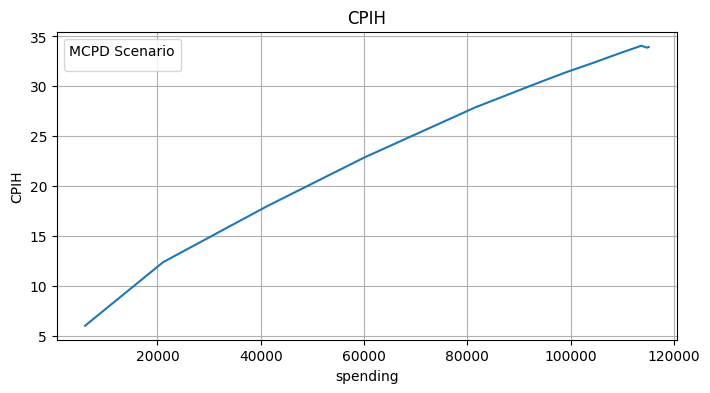

In [138]:
# viev 1: new dx over 52 weeks by different mcpd scenarios
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_inc_wad_agg, x='spending', y='CPIH')

# Customize the plot
plt.title('CPIH')
plt.xlabel('spending')
plt.ylabel('CPIH')
plt.legend(title='MCPD Scenario')
plt.grid(True)

# Show the plot
plt.show()

/var/folders/d8/0ml7793s3d1c9g2vzlb7wkb40000gn/T/ipykernel_67912/1684340044.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='MCPD Scenario')


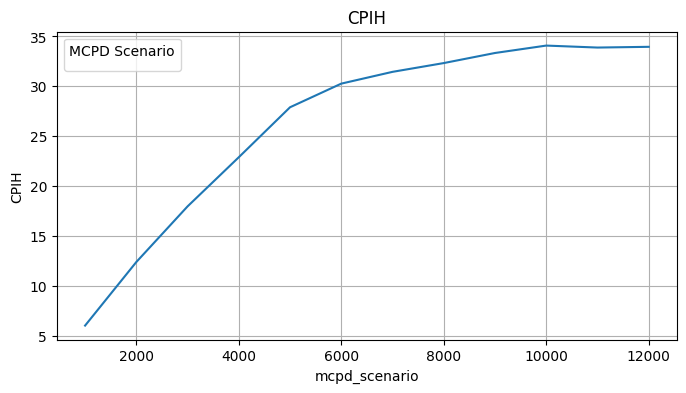

In [139]:
# viev 1: new dx over 52 weeks by different mcpd scenarios
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_inc_wad_agg, x='mcpd_scenario', y='CPIH')

# Customize the plot
plt.title('CPIH')
plt.xlabel('mcpd_scenario')
plt.ylabel('CPIH')
plt.legend(title='MCPD Scenario')
plt.grid(True)

# Show the plot
plt.show()